<a href="https://colab.research.google.com/github/ToyTeX/NumericalNotebooks/blob/main/TriDiagonalLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Results Table:
 p     h        ||u_h - y_h||_∞    ||u_h - y_h||_∞/h²    CPU Time    CPU Time/n
---------------------------------------------------------------------------------
 1  0.500000    6.807707e-02    2.723083e-01    0.000006  5.722046e-06
 2  0.250000    2.001197e-02    3.201915e-01    0.000014  4.529953e-06
 3  0.125000    5.479204e-03    3.506690e-01    0.000021  2.929143e-06
 4  0.062500    1.385066e-03    3.545769e-01    0.000068  4.514058e-06
 5  0.031250    3.486009e-04    3.569673e-01    0.000140  4.506880e-06
 6  0.015625    8.721312e-05    3.572249e-01    0.000260  4.132589e-06
 7  0.007812    2.180722e-05    3.572894e-01    0.000506  3.987410e-06
 8  0.003906    5.452050e-06    3.573056e-01    0.001158  4.542108e-06
 9  0.001953    1.363031e-06    3.573104e-01    0.001493  2.921677e-06
10  0.000977    3.407598e-07    3.573125e-01    0.003843  3.756666e-06

Trend Analysis:
Column 1 (p): Refinement level
Column 2 (h): Mesh size, halves each step
Column 3 (||error||_∞)

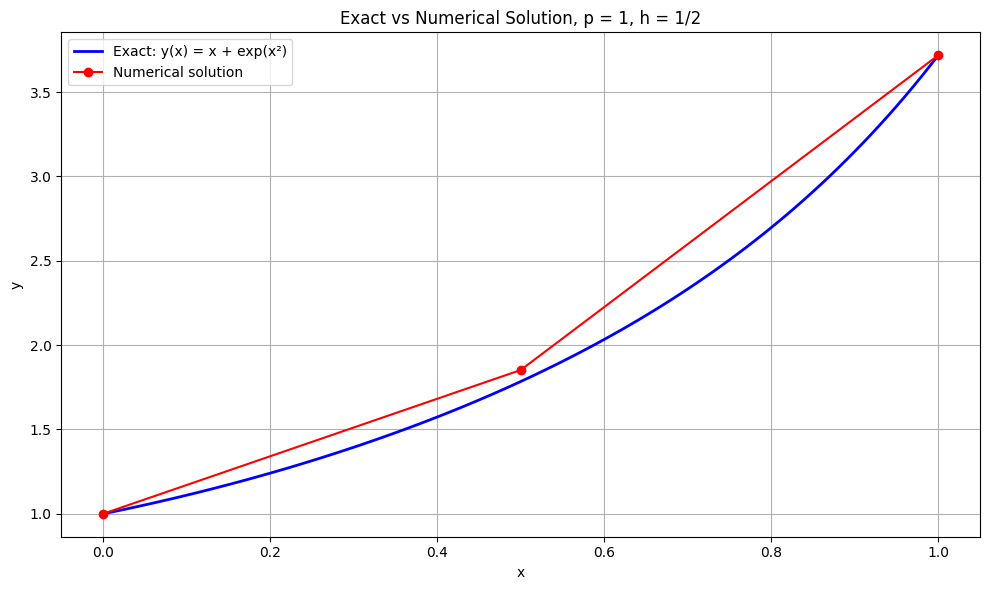

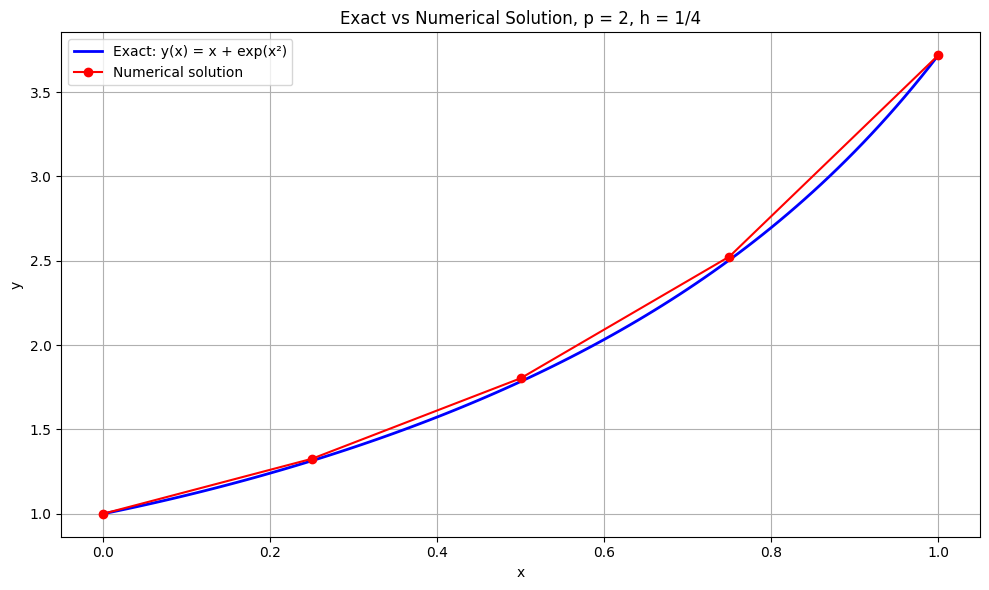

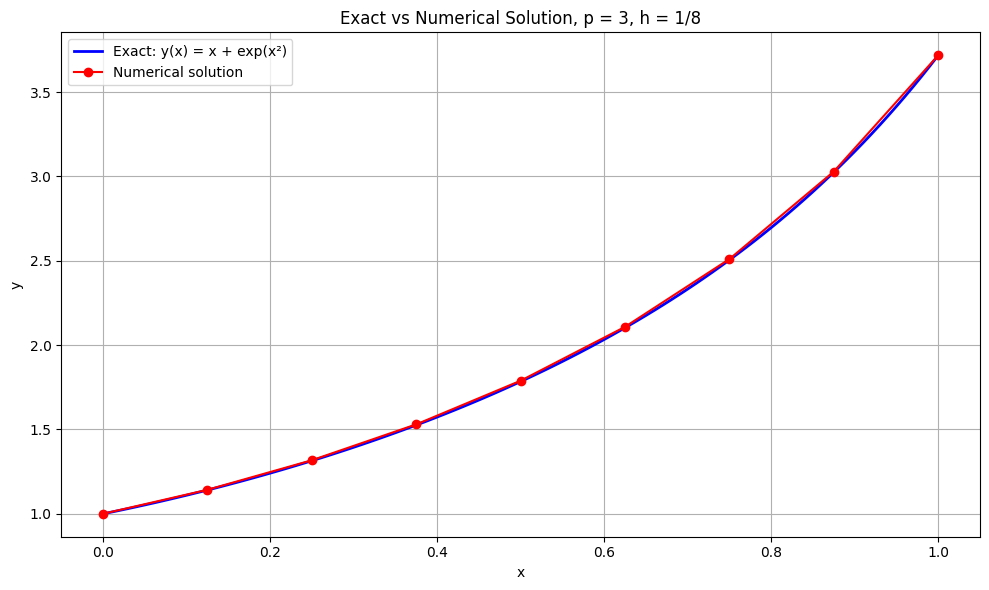

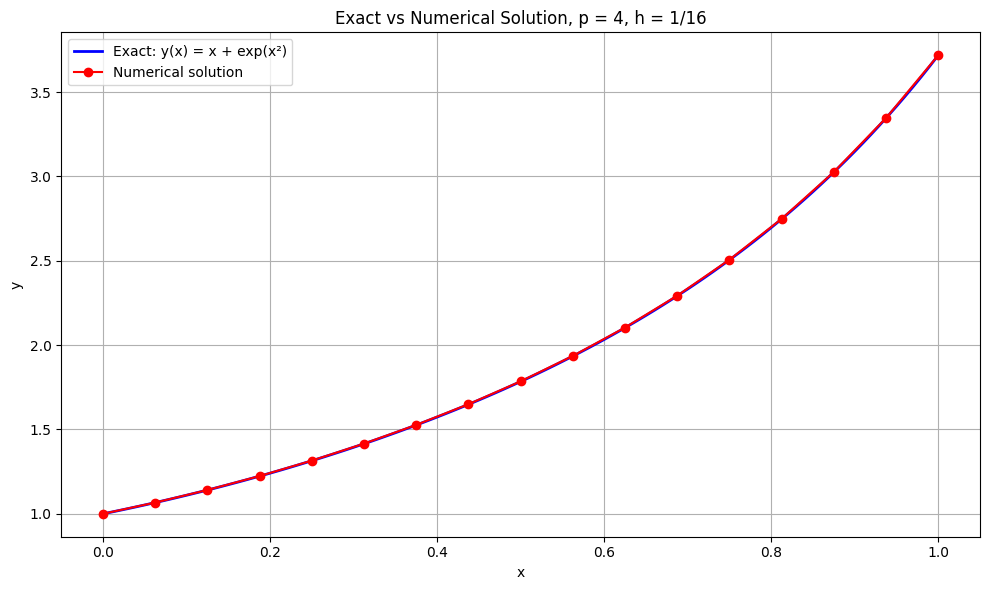


Verification at x = 0.5:
LHS: -y'' + d(x)y = 1.500000
RHS: f(x) = 1.500000
Difference: 4.44e-16


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

def bvp1d():
    """
    Numerical solution of a two-point boundary value problem
    -y'' + d(x)y = f(x), y(0) = alpha, y(1) = beta
    where d(x) = 4x^2 + 2, f(x) = 2x(1 + 2x^2)
    Exact solution: y(x) = x + exp(x^2)
    """

    # Boundary conditions
    alpha = 1
    beta = 1 + np.exp(1)

    # Initialize table for results
    results_table = []

    for p in range(1, 11):  # p = 1 to 10
        n = 2**p - 1
        h = 1 / (n + 1)  # mesh size

        # Initialize arrays
        xh = np.zeros(n)
        yh = np.zeros(n)
        a = np.zeros(n)  # subdiagonal
        b = np.zeros(n)  # main diagonal
        c = np.zeros(n)  # superdiagonal
        f = np.zeros(n)  # right hand side

        # Set up the discretized system
        for i in range(n):
            xh[i] = (i + 1) * h  # mesh points x_i = ih for i = 1, ..., n
            yh[i] = xh[i] + np.exp(xh[i]**2)  # exact solution at mesh points

            # The BVP is: -y'' + d(x)y = f(x)
            # Using central difference: -y''_i ≈ -(y_{i+1} - 2y_i + y_{i-1})/h^2
            # So: -(y_{i+1} - 2y_i + y_{i-1})/h^2 + d(x_i)y_i = f(x_i)
            # Rearranging: -y_{i-1}/h^2 + (2/h^2 + d(x_i))y_i - y_{i+1}/h^2 = f(x_i)
            # In matrix form: a_i*y_{i-1} + b_i*y_i + c_i*y_{i+1} = f_i

            d_i = 4 * xh[i]**2 + 2  # coefficient d(x) = 4x^2 + 2

            a[i] = -1 / h**2     # coefficient of y_{i-1}
            b[i] = 2 / h**2 + d_i # coefficient of y_i
            c[i] = -1 / h**2     # coefficient of y_{i+1}
            f[i] = 2 * xh[i] * (1 + 2 * xh[i]**2)  # right hand side f(x) = 2x(1 + 2x^2)

        # Adjust for boundary conditions
        # For i=0: a[0]*y_{-1} + b[0]*y_0 + c[0]*y_1 = f[0]
        # Since y_{-1} = y(0) = alpha, we move a[0]*alpha to RHS
        f[0] = f[0] - a[0] * alpha
        a[0] = 0  # no subdiagonal for first equation

        # For i=n-1: a[n-1]*y_{n-2} + b[n-1]*y_{n-1} + c[n-1]*y_n = f[n-1]
        # Since y_n = y(1) = beta, we move c[n-1]*beta to RHS
        f[n-1] = f[n-1] - c[n-1] * beta
        c[n-1] = 0  # no superdiagonal for last equation

        # Solve the system
        t0 = time.time()
        wh = LU_solve(a, b, c, f)  # numerical solution
        t1 = time.time() - t0

        # Calculate error
        error_inf = np.linalg.norm(yh - wh, np.inf)

        # Store results
        results_table.append([
            p,                    # column 1: p
            h,                    # column 2: h
            error_inf,            # column 3: ||u_h - y_h||_∞
            error_inf / h**2,     # column 4: ||u_h - y_h||_∞/h²
            t1,                   # column 5: CPU time
            t1 / n                # column 6: CPU time/n
        ])

        # Plot for first few values of p
        if p <= 4:
            plt.figure(p, figsize=(10, 6))
            x_fine = np.linspace(0, 1, 101)
            y_exact = x_fine + np.exp(x_fine**2)

            # Plot exact solution
            plt.plot(x_fine, y_exact, 'b-', linewidth=2, label='Exact: y(x) = x + exp(x²)')

            # Plot numerical solution
            x_numerical = np.concatenate(([0], xh, [1]))
            y_numerical = np.concatenate(([alpha], wh, [beta]))
            plt.plot(x_numerical, y_numerical, 'ro-', markersize=6, linewidth=1.5,
                    label='Numerical solution')

            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(f'Exact vs Numerical Solution, p = {p}, h = 1/{2**p}')
            plt.legend(loc='upper left')
            plt.grid(True)
            plt.tight_layout()

    # Display results table
    print("\nResults Table:")
    print(" p     h        ||u_h - y_h||_∞    ||u_h - y_h||_∞/h²    CPU Time    CPU Time/n")
    print("---------------------------------------------------------------------------------")

    for row in results_table:
        print(f"{row[0]:2.0f}  {row[1]:8.6f}  {row[2]:14.6e}  {row[3]:14.6e}  {row[4]:10.6f}  {row[5]:12.6e}")

    # Analysis
    print("\nTrend Analysis:")
    print("Column 1 (p): Refinement level")
    print("Column 2 (h): Mesh size, halves each step")
    print("Column 3 (||error||_∞): Should decrease as O(h²)")
    print("Column 4 (||error||_∞/h²): Should approach constant (convergence rate check)")
    print("Column 5 (CPU time): Increases with problem size")
    print("Column 6 (CPU time/n): Should remain roughly constant for O(n) algorithm")

    # Convert to numpy array for easier handling
    results_array = np.array(results_table)
    print(f"\nResults shape: {results_array.shape}")

    # Show plots
    plt.show()

    return results_array


def LU_solve(a, b, c, f):
    """
    Solve tridiagonal system using LU decomposition

    Parameters:
    -----------
    a : array_like
        Subdiagonal elements
    b : array_like
        Main diagonal elements
    c : array_like
        Superdiagonal elements
    f : array_like
        Right hand side vector

    Returns:
    --------
    w : ndarray
        Solution vector
    """

    n = len(f)

    # Step 1: LU decomposition
    # For tridiagonal matrix A = LU where:
    # L has 1's on diagonal and l_i on subdiagonal
    # U has u_i on diagonal and c_i on superdiagonal

    # Initialize
    l = np.zeros(n)  # subdiagonal of L
    u = np.zeros(n)  # diagonal of U

    # LU decomposition
    u[0] = b[0]
    for i in range(1, n):
        l[i] = a[i] / u[i-1]
        u[i] = b[i] - l[i] * c[i-1]

    # Step 2: Forward substitution - solve Lz = f
    z = np.zeros(n)
    z[0] = f[0]
    for i in range(1, n):
        z[i] = f[i] - l[i] * z[i-1]

    # Step 3: Back substitution - solve Uw = z
    w = np.zeros(n)
    w[n-1] = z[n-1] / u[n-1]
    for i in range(n-2, -1, -1):
        w[i] = (z[i] - c[i] * w[i+1]) / u[i]

    return w


def run_extended_analysis(max_p=25):
    """
    Run analysis for larger values of p (up to max_p)
    Use this for the full analysis requested in the homework
    """
    print(f"Running extended analysis for p = 1 to {max_p}...")
    print("Warning: This may take some time for large values of p")

    # Boundary conditions
    alpha = 1
    beta = 1 + np.exp(1)

    # Initialize table for results
    results_table = []

    for p in range(1, max_p + 1):
        n = 2**p - 1
        h = 1 / (n + 1)

        # Initialize arrays
        xh = np.zeros(n)
        yh = np.zeros(n)
        a = np.zeros(n)
        b = np.zeros(n)
        c = np.zeros(n)
        f = np.zeros(n)

        # Set up for numerical solution
        for i in range(n):
            xh[i] = (i + 1) * h
            yh[i] = xh[i] + np.exp(xh[i]**2)

            d_i = 4 * xh[i]**2 + 2

            a[i] = -1 / h**2
            b[i] = 2 / h**2 + d_i
            c[i] = -1 / h**2
            f[i] = 2 * xh[i] * (1 + 2 * xh[i]**2)

        # Adjust for boundary conditions
        f[0] = f[0] - a[0] * alpha
        f[n-1] = f[n-1] - c[n-1] * beta

        # Set unused boundary coefficients to zero
        a[0] = 0
        c[n-1] = 0

        # Solve the system
        t0 = time.time()
        wh = LU_solve(a, b, c, f)
        t1 = time.time() - t0

        # Calculate error
        error_inf = np.linalg.norm(yh - wh, np.inf)

        # Store results
        results_table.append([
            p, h, error_inf, error_inf / h**2, t1, t1 / n
        ])

        if p % 5 == 0:  # Progress indicator
            print(f"Completed p = {p}, n = {n}, error = {error_inf:.6e}")

    # Display results table
    print(f"\nExtended Results Table (p = 1 to {max_p}):")
    print(" p     h        ||u_h - y_h||_∞    ||u_h - y_h||_∞/h²    CPU Time    CPU Time/n")
    print("---------------------------------------------------------------------------------")

    for row in results_table:
        print(f"{row[0]:2.0f}  {row[1]:8.6f}  {row[2]:14.6e}  {row[3]:14.6e}  {row[4]:10.6f}  {row[5]:12.6e}")

    return np.array(results_table)


# Test the corrected implementation
if __name__ == "__main__":
    # Run the basic analysis
    results = bvp1d()

    # Verify the exact solution satisfies the differential equation at a test point
    x_test = 0.5
    y_exact = x_test + np.exp(x_test**2)
    y_prime = 1 + 2*x_test*np.exp(x_test**2)  # derivative
    y_double_prime = 2*np.exp(x_test**2) + 4*x_test**2*np.exp(x_test**2)  # second derivative
    d_x = 4*x_test**2 + 2
    f_x = 2*x_test*(1 + 2*x_test**2)

    lhs = -y_double_prime + d_x*y_exact
    print(f"\nVerification at x = {x_test}:")
    print(f"LHS: -y'' + d(x)y = {lhs:.6f}")
    print(f"RHS: f(x) = {f_x:.6f}")
    print(f"Difference: {abs(lhs - f_x):.2e}")

In [ ]:
results_extended = run_extended_analysis(25)

Running extended analysis for p = 1 to 25...
Completed p = 5, n = 31, error = 3.486009e-04
Completed p = 10, n = 1023, error = 3.407598e-07
Completed p = 15, n = 32767, error = 7.870868e-10
Completed p = 20, n = 1048575, error = 8.297652e-07
Completed p = 25, n = 33554431, error = 3.750541e-03

Extended Results Table (p = 1 to 25):
 p     h        ||u_h - y_h||_∞    ||u_h - y_h||_∞/h²    CPU Time    CPU Time/n
---------------------------------------------------------------------------------
 1  0.500000    6.807707e-02    2.723083e-01    0.000011  1.072884e-05
 2  0.250000    2.001197e-02    3.201915e-01    0.000020  6.596247e-06
 3  0.125000    5.479204e-03    3.506690e-01    0.000034  4.802431e-06
 4  0.062500    1.385066e-03    3.545769e-01    0.000067  4.450480e-06
 5  0.031250    3.486009e-04    3.569673e-01    0.000128  4.137716e-06
 6  0.015625    8.721312e-05    3.572249e-01    0.000268  4.253690e-06
 7  0.007812    2.180722e-05    3.572894e-01    0.000537  4.225829e-06
 8  0.0

##Discussion

- Col 1 (p): p is the refinement parameter/level of discretization for the mesh point set. For each p, the number of interior points is n = 2^p - 1.  We increase p from 1 to 25 in this column, which will in turn affect the mesh size h.   
- Col 2 (h): The mesh size is  h = 1/(n+1) where n = 2^p - 1, so h = 1/2^p.  As exepcted, this column shows exponential decay by a factor of 2 with each increment of p.
- Col 3:  The max error norm decreases rapidly from around p 1 to 16 as expected for our second order finite difference scheme, but then starts to increase as our mesh becomes finer (likely due to round off error).  
- Col 4:  By calculating the error \infty/h^2 as h \to 0, we attempt to extract a constant c.  If the ratio stabilizes, this indicates that our method is indeed 2nd order.  For p 1 to 13 or so within our error scaled by h^2, we see stabilization around .357.  
- Col 5 (CPU time): The CPU time grows exponentially with p as expected
- Col 6 (CPU time/n):  Remains relatively stable, as one might expect for an O(n) algorithm